In [1]:
from google.colab import drive
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.word2vec import LineSentence
from gensim.test.utils import datapath
from gensim import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
drive.mount('/content/drive')
path = "drive/MyDrive/Colab Notebooks/Topicos/dados"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bag of Words

In [9]:
def to_lowercase(data):
    return [line.replace(line, line.lower()) for line in data]

def remove_stopwords(data):
    stop_words = stopwords.words('portuguese')
    splited_tokens = [word_tokenize(line, language='portuguese') for line in data]
    filtered_tokens = splited_tokens

    for line in filtered_tokens:
      for word in line:
        if word in stop_words:
          line.remove(word)

    return filtered_tokens

def remove_punct(data):
    #regex para tudo que não for [A-Za-Z0-9] e espaçamento 
    return [re.sub(r'[^\w\s]', '', str(line)) for line in data]

def preprocess_text(data):
    
    #data = remove_punct(data)
    #data = to_lowercase(data)
    data = remove_stopwords(data)

    return data        

# Word2Vec

In [10]:
def get_data_for_embbedings():
    
    denuncias = pd.read_csv(path+'/irregularidades.csv', sep=',')
    data = []
    data.extend(denuncias['text'].values)

    return data

def train_and_save(vec_size, method):

    embedding_data = get_data_for_embbedings() 
    sents = preprocess_text(embedding_data)
    model = Word2Vec(sentences = sents, sg = method, window=4, min_count=1, sample=1e-4, workers=5)
    if method == 0:
      file_name = 'cbow_' + str(vec_size)+ '_word2vec.model'
    else:
      file_name = 'skip_' + str(vec_size)+ '_word2vec.model'

    model.save(path+'/'+ file_name)

from sklearn.manifold import TSNE

def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

## Criação das embeddings Word2Vec

In [11]:
###Treino da Embedding###
vec_size = 100
# value 0 for CBOW(default), and 1 for skip gram
algorithm = 0
train_and_save(vec_size, algorithm)
print('Vector size ' + str(vec_size) + ' done!')
algorithm = 1
train_and_save(vec_size, algorithm)
print('Vector size ' + str(vec_size) + ' done!')


Vector size 100 done!
Vector size 100 done!


## Carregar as embbedings treinadas para uso

In [12]:
model_cbow_fp = path+'/cbow_100_word2vec.model'
model_skip_fp = path+'/skip_100_word2vec.model'

## CBOW

In [13]:
w2v_model = Word2Vec.load(model_cbow_fp)
words = list(w2v_model.wv.vocab)
print(words)

['licitacao', 'publicada', 'prazo', 'tce', 'dia', 'abertura', 'dados', 'orgao', 'publico', 'p', 'm', 'miguel', 'alves', 'processo', 'lw', 'procedimento', 'administrativo', 'tipo', 'objeto', 'obras', 'servicos', 'engenharia', 'contratacao', 'empresa', 'execucao', 'reformas', 'ubs', 'sao', 'municipio', 'dt', 'cadastro', 'ult', 'alteracao', 'venho', 'informar', 'atraves', 'deste', 'divergencia', 'valores', 'edital', 'planilha', 'orcamentaria', 'anexados', 'tribunal', 'contas', 'referente', 'tomada', 'precos', 'ndeg', 'secretaria', 'agronegocio', 'empreendedorismo', 'rural', 'constitui', 'presente', 'pavimentacao', 'paralelepipedo', 'vias', 'publicas', 'riacho', 'friopi', 'conforme', 'discriminadas', 'projeto', 'basico', 'mediante', 'regime', 'empreitada', 'preco', 'unitario', 'lagoa', 'sitio', 'compra', 'material', 'permanente', 'ramo', 'forma', 'parcelada', 'objetivando', 'fornecimento', 'equipamentos', 'informatica', 'suprir', 'necessidades', 'atividades', 'diarias', 'municipal', 'saude

### Verificar os *n* termos mais similares

In [14]:
print(w2v_model.wv.most_similar(positive='licitacao', topn=10))

[('objeto', 0.47994446754455566), ('analise', 0.4280455708503723), ('ate', 0.4061228632926941), ('ainda', 0.39845865964889526), ('saber', 0.3816721737384796), ('m', 0.38051682710647583), ('agosto', 0.37602052092552185), ('investigacao', 0.3740607500076294), ('prefeitura', 0.36891287565231323), ('saude', 0.3689092695713043)]


### Região do espaço vetorial dos termos similares

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


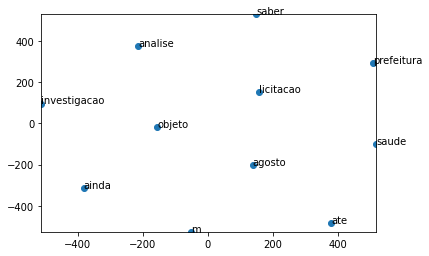

In [15]:
display_closestwords_tsnescatterplot(w2v_model, 'licitacao', 100)

## SKIP-GRAM

In [16]:
w2v_model = Word2Vec.load(model_skip_fp)
words = list(w2v_model.wv.vocab)
print(words)

['licitacao', 'publicada', 'prazo', 'tce', 'dia', 'abertura', 'dados', 'orgao', 'publico', 'p', 'm', 'miguel', 'alves', 'processo', 'lw', 'procedimento', 'administrativo', 'tipo', 'objeto', 'obras', 'servicos', 'engenharia', 'contratacao', 'empresa', 'execucao', 'reformas', 'ubs', 'sao', 'municipio', 'dt', 'cadastro', 'ult', 'alteracao', 'venho', 'informar', 'atraves', 'deste', 'divergencia', 'valores', 'edital', 'planilha', 'orcamentaria', 'anexados', 'tribunal', 'contas', 'referente', 'tomada', 'precos', 'ndeg', 'secretaria', 'agronegocio', 'empreendedorismo', 'rural', 'constitui', 'presente', 'pavimentacao', 'paralelepipedo', 'vias', 'publicas', 'riacho', 'friopi', 'conforme', 'discriminadas', 'projeto', 'basico', 'mediante', 'regime', 'empreitada', 'preco', 'unitario', 'lagoa', 'sitio', 'compra', 'material', 'permanente', 'ramo', 'forma', 'parcelada', 'objetivando', 'fornecimento', 'equipamentos', 'informatica', 'suprir', 'necessidades', 'atividades', 'diarias', 'municipal', 'saude

### Verificar os *n* termos mais similares

In [17]:
print(w2v_model.wv.most_similar(positive='licitacao', topn=10))

[('nao', 0.9983491897583008), ('objeto', 0.9983422756195068), ('processo', 0.9982179999351501), ('municipal', 0.9981746077537537), ('municipio', 0.9981597065925598), ('ainda', 0.9981438517570496), ('cargo', 0.9980695247650146), ('publico', 0.9980454444885254), ('lei', 0.9980076551437378), ('ser', 0.9979987144470215)]


### Região do espaço vetorial dos termos similares

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


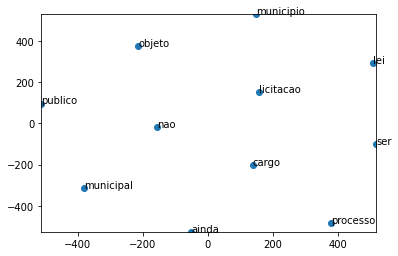

In [18]:
display_closestwords_tsnescatterplot(w2v_model, 'licitacao', 100)

## Embbeddings NILC

In [19]:
###Embeddings NILC###
#in_fp = path+'/cbow_s100.txt'
#w2v_model = KeyedVectors.load_word2vec_format(in_fp)

### *N* termos mais similares

In [20]:
#print(w2v_model.wv.most_similar(positive='contrato', topn=10))

### Região do espaço vetorial dos termos similares

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


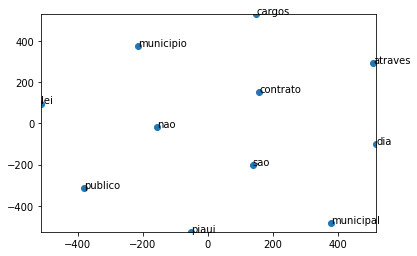

In [21]:
display_closestwords_tsnescatterplot(w2v_model, 'contrato', 100)

# Doc2Vec

## Criação das Embeddings Doc2vec

In [22]:
def prepare_corpus(tweets: list):
    for i, line in enumerate(tweets):
        tokens = gensim.utils.simple_preprocess(line)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

def train_and_save(vec_size, dm_option,dbow_option):

    data = get_data_for_embbedings() 
    documents = list(prepare_corpus(data))
    #model = Doc2Vec(vector_size=vec_size, window=4, min_count=1, epochs=300, sample=1e-4, workers=5)
    model = Doc2Vec(vector_size = vec_size, dm=dm_option, dbow_words = dbow_option, window=4, min_count=2, epochs=300, sample=1e-4, workers=5)
    model.build_vocab(documents)
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
    if dm_option == 1:
        file_name = 'DM_' + str(vector_size) + '_doc2vec.model'
    else:
        file_name = 'DBOW_' + str(vector_size) + '_doc2vec.model'
    
    model.save(path+'/'+ file_name)

In [23]:
data = get_data_for_embbedings() 
documents = list(prepare_corpus(data))
print(documents[:2])

[TaggedDocument(words=['licitacao', 'publicada', 'prazo', 'publicada', 'tce', 'dia', 'abertura', 'dia', 'dados', 'licitacao', 'orgao', 'publico', 'miguel', 'alves', 'processo', 'tce', 'lw', 'procedimento', 'processo', 'administrativo', 'tipo', 'objeto', 'obras', 'servicos', 'engenharia', 'objeto', 'contratacao', 'empresa', 'execucao', 'reformas', 'ubs', 'sao', 'miguel', 'municipio', 'miguel', 'alves', 'dt', 'abertura', 'dt', 'cadastro', 'dt', 'ult', 'alteracao'], tags=[0]), TaggedDocument(words=['venho', 'informar', 'atraves', 'deste', 'divergencia', 'valores', 'edital', 'planilha', 'orcamentaria', 'anexados', 'tribunal', 'contas', 'referente', 'tomada', 'precos', 'processo', 'ndeg', 'dados', 'licitacao', 'orgao', 'publico', 'secretaria', 'agronegocio', 'rural', 'processo', 'tce', 'lw', 'procedimento', 'processo', 'administrativo', 'tipo', 'objeto', 'obras', 'servicos', 'engenharia', 'objeto', 'constitui', 'objeto', 'presente', 'edital', 'contratacao', 'empresa', 'engenharia', 'execuca

In [24]:
vector_size = 300
dm_option = 1
dbow_option = 1
train_and_save(vector_size, dm_option, dbow_option)
print('Vector size ' + str(vector_size) + ' done!')

dm_option = 2
train_and_save(vector_size, dm_option, dbow_option)
print('Vector size ' + str(vector_size) + ' done!')

Vector size 300 done!
Vector size 300 done!


## Carregar o modelo salvo

In [25]:
filepath = path+'/DM_300_doc2vec.model'
d2v_model = Doc2Vec.load(filepath)

## Verificando similariade

In [26]:
print(d2v_model.wv.most_similar(positive='licitacao', topn = 10))

[('tce', 0.7348222136497498), ('orgao', 0.7333898544311523), ('dados', 0.725977897644043), ('lw', 0.6929720044136047), ('processo', 0.6841155290603638), ('procedimento', 0.6797873973846436), ('administrativo', 0.6451455354690552), ('tipo', 0.6186108589172363), ('objeto', 0.586846649646759), ('abreu', 0.537035346031189)]


# Métodos auxiliares para a classificação

## Uso das embeddings para os modelos de Classificação

In [27]:
#Método infer_vector() é responsável por gerar as embeddings nos dados que serão utilizados para as tarefas de ML
def transform_d2v_embeddings(d2v_model, X):
    train_data = []
    
    for i in range(len(X)):
        model_vector = d2v_model.infer_vector(gensim.utils.simple_preprocess(X[i]))
        train_data.append(model_vector)
        
    return train_data

#Método abaixo computa a média das embeddings de cada termo dado as sentenças de entrada.
def transform_w2v_embeddings(X, w2v_model, vec_size):
    
    X_emb = np.zeros((len(X),vec_size), dtype='float64')
    n = 0
    
    for i in X:
        '''
        if n % 1000 == 0:
            print('Data %d of %d', (n, len(X)))
        '''   
        X_emb[n] = compute_mean_embeddings(i, w2v_model, vec_size)
        n = n + 1 
    
    return X_emb

## Computa a média de todos as embeddings em um documento/sentença/parágrafo
def compute_mean_embeddings(tokens, w2v_model, vec_size):
    
    emb_features = np.zeros(vec_size, dtype='float64')
    n = 0
    
    #Conjunto com todos os vetores de palavras do modelo treinado
    index2word_set = set(w2v_model.wv.index2word)
    
    for w in tokens:
      #se o token estiver no conjunto, recupera a embedding
        if w in index2word_set:
            n = n + 1
            emb_features = np.add(emb_features, w2v_model[w])
    #Cálculo da média
    emb_features = np.divide(emb_features, n)
    
    return emb_features

## Métodos para os Classificadores

In [28]:
def read_corpus(data_filepath):
    
    data = pd.read_csv(corpus_filepath, sep=',')
    
    X = []
    y = []
    X.extend(data['text'].values)
    y.extend(data['prediction'].values)
   
    return X, y  

def split_data_set(X, y, size):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y, test_size = size, random_state = 42)

    return X_train, X_test, y_train, y_test
    
def run_classifier(classifier, X_train, X_test, y_train, y_test):
    
    classifier.fit(X_train,y_train)
    
    pred = classifier.predict(X_test)
    
    classif_report = classification_report(y_test, pred)
    
    return classif_report

# Aplicação dos modelos em Algoritmos de Aprendizagem de Máquina Supervisionada

## Córpus

In [30]:
corpus_filepath = path+'/irregularidades.csv'
#corpus_filepath = path+'/covid_testar_4.csv'

X, y = read_corpus(corpus_filepath)

## Modelo Bag of Words

In [31]:
def bag_of_words_vectorizer(data, n_range):
    
    vectorizer = CountVectorizer(strip_accents='ascii', analyzer='word', ngram_range=(1, n_range))
    X_bow = vectorizer.fit_transform(data)
    
    return X_bow, vectorizer

In [32]:
X1, vec_bow = bag_of_words_vectorizer(X, 1)
X_train, X_test, y_train, y_test = split_data_set(X1,y,0.3)
print(run_classifier(SGDClassifier(max_iter=1000, tol=1e-3),X_train, X_test, y_train, y_test))

              precision    recall  f1-score   support

           1       1.00      0.91      0.95        44
           2       0.88      0.64      0.74        11
           3       0.67      0.55      0.60        11
           4       0.50      0.50      0.50         2
           5       0.64      1.00      0.78         7
           6       0.60      0.75      0.67         8
           7       0.60      0.75      0.67         8
           8       0.40      0.50      0.44         4

    accuracy                           0.79        95
   macro avg       0.66      0.70      0.67        95
weighted avg       0.82      0.79      0.79        95



## Modelo TF-IDF

In [33]:
def tf_idf_vectorizer(data, n_range):
       
    vectorizer = TfidfVectorizer(strip_accents='ascii', analyzer='word', ngram_range=(1, n_range))
    X_tfidf =  vectorizer.fit_transform(data)
    
    return X_tfidf,vectorizer

In [34]:
X1, vec_tf_idf = tf_idf_vectorizer(X, 1)
X_train, X_test, y_train, y_test = split_data_set(X1,y,0.3)
print(run_classifier(SGDClassifier(max_iter=1000, tol=1e-3),X_train, X_test, y_train, y_test))

              precision    recall  f1-score   support

           1       0.98      0.95      0.97        44
           2       0.67      0.73      0.70        11
           3       1.00      0.55      0.71        11
           4       0.50      0.50      0.50         2
           5       0.75      0.86      0.80         7
           6       0.86      0.75      0.80         8
           7       0.62      1.00      0.76         8
           8       0.50      0.50      0.50         4

    accuracy                           0.83        95
   macro avg       0.73      0.73      0.72        95
weighted avg       0.86      0.83      0.83        95



## Modelo Word2Vec

### Word2Vec - CBOW

In [35]:
vec_size = 100
model_cbow_fp = path+'/cbow_100_word2vec.model'
w2v_model = Word2Vec.load(model_cbow_fp)
X1 = transform_w2v_embeddings(X, w2v_model, vec_size)
X_train, X_test, y_train, y_test = split_data_set(X1,y,0.3)
print(run_classifier(SGDClassifier(max_iter=1000, tol=1e-3),X_train, X_test, y_train, y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


              precision    recall  f1-score   support

           1       0.46      1.00      0.63        44
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         4

    accuracy                           0.46        95
   macro avg       0.06      0.12      0.08        95
weighted avg       0.21      0.46      0.29        95



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Word2Vec - Skip-gram

In [36]:
vec_size = 100
model_skip_fp = path+'/skip_100_word2vec.model'
w2v_model = Word2Vec.load(model_skip_fp)
X1 = transform_w2v_embeddings(X, w2v_model, vec_size)
X_train, X_test, y_train, y_test = split_data_set(X1,y,0.3)
print(run_classifier(SGDClassifier(max_iter=1000, tol=1e-3),X_train, X_test, y_train, y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11
           4       0.02      1.00      0.04         2
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         4

    accuracy                           0.02        95
   macro avg       0.00      0.12      0.01        95
weighted avg       0.00      0.02      0.00        95



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Modelo Doc2Vec

### Doc2Vec DM

In [37]:
filepath = path+'/DM_300_doc2vec.model'
d2v_model = Doc2Vec.load(filepath)
X1 = transform_d2v_embeddings(d2v_model, X)
X_train, X_test, y_train, y_test = split_data_set(X1,y,0.3)
print(run_classifier(SGDClassifier(max_iter=1000, tol=1e-3),X_train, X_test, y_train, y_test))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97        44
           2       0.62      0.73      0.67        11
           3       0.88      0.64      0.74        11
           4       0.33      0.50      0.40         2
           5       0.70      1.00      0.82         7
           6       0.71      0.62      0.67         8
           7       0.80      0.50      0.62         8
           8       0.50      0.50      0.50         4

    accuracy                           0.81        95
   macro avg       0.69      0.68      0.67        95
weighted avg       0.82      0.81      0.81        95



### Doc2Vec DBOW

In [47]:
filepath = path+'/DBOW_300_doc2vec.model'
d2v_model = Doc2Vec.load(filepath)
X1 = transform_d2v_embeddings(d2v_model, X)
X_train, X_test, y_train, y_test = split_data_set(X1,y,0.3)
print(run_classifier(SGDClassifier(max_iter=1000, tol=1e-3),X_train, X_test, y_train, y_test))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        44
           2       0.86      0.55      0.67        11
           3       0.50      0.82      0.62        11
           4       1.00      0.50      0.67         2
           5       0.86      0.86      0.86         7
           6       0.75      0.75      0.75         8
           7       0.80      1.00      0.89         8
           8       0.00      0.00      0.00         4

    accuracy                           0.82        95
   macro avg       0.71      0.68      0.68        95
weighted avg       0.81      0.82      0.81        95



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
